# CMSC320 - Introduction to Data Science
## Final Tutorial
#### David Martin
---

The purpose of this tutorial is to perform an analysis of COVID data across the state of Virginia.

In [27]:
import pandas as pd
import datetime 
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

## Data Collection

Lets start by pulling the data from the dataset "VDH-COVID-19-PublicUseDataset-Cases" as found on data.virginia.gov, and taking a look at what it contains:

https://data.virginia.gov/Government/VDH-COVID-19-PublicUseDataset-Cases/bre9-aqqr

I uploaded the .csv to my GitHub at the following link:

https://github.com/martindavid1995/Data-Science-Tutorial

In [28]:
# Pull data on COVID cases across Virginia
covid_data = pd.read_csv("https://raw.githubusercontent.com/martindavid1995/Data-Science-Tutorial/master/Covid_VA.csv")
covid_data.head()

,Report Date,FIPS,Locality,VDH Health District,Total Cases,Hospitalizations,Deaths
0,03/17/2020,51001,Accomack,Eastern Shore,0,0,0
1,03/17/2020,51003,Albemarle,Thomas Jefferson,0,0,0
2,03/17/2020,51005,Alleghany,Alleghany,0,0,0
3,03/17/2020,51007,Amelia,Piedmont,0,0,0
4,03/17/2020,51009,Amherst,Central Virginia,0,0,0


## Data Management

Now that we have our dataset imported, lets start looking at what we have to work with. In order to visualize our data, we should look to find what 

In [29]:
print("Total number of columns in the dataset: ",len(covid_data.index))

Total number of columns in the dataset:  103607


As we can see, we have a pretty large set of data. Over 100,000 rows with seemingly an entry for each locality for each date within the specified range. Lets see what the day range looks like:

In [41]:
# Prints the minimum and maximum values of a specified column in a DataFrame
def printMinMax(df, column):
    print("Min: ",df[column].min())
    print("Max: ",df[column].max())
    
printMinMax(covid_data, "Report Date")

Min:  01/01/2021
Max:  12/31/2021


If we look at the results of the above cell, we notice our first issue with this dataset. The date range from the days above shows January 1, 2021 as being the earliest recorded date when we can clearly see from the head output in the above cells that we have columns with dates going back into 2020. This must be because there is some inability to compare these date objects in the current dataframe accurately. Lets convert the dates into DateTime objects so we can figure out our actual date range, and manipulate and visualize our data better.

In [42]:
# Split each date string into its components
def dateToDateTime(date: str):
    split = date.split("/")
    month = int(split[0])
    day = int(split[1])
    year = int(split[2])
    # Return a new DateTime object 
    return datetime.date(year, month, day)
    
# Convert each row's Report Date into a readable DateTime
def convertDateTime(df):
    datetimes = []
    for index,row in df.iterrows():
        date = df.at[index, "Report Date"]
        datetimes.append(dateToDateTime(date))
    
    # Add the new DateTimes to the original DataFrame
    df['DateTime'] = datetimes
    return df

covid_data = convertDateTime(covid_data)
covid_data.head()

,Report Date,FIPS,Locality,VDH Health District,Total Cases,Hospitalizations,Deaths,DateTime
0,03/17/2020,51001,Accomack,Eastern Shore,0,0,0,2020-03-17
1,03/17/2020,51003,Albemarle,Thomas Jefferson,0,0,0,2020-03-17
2,03/17/2020,51005,Alleghany,Alleghany,0,0,0,2020-03-17
3,03/17/2020,51007,Amelia,Piedmont,0,0,0,2020-03-17
4,03/17/2020,51009,Amherst,Central Virginia,0,0,0,2020-03-17


With the new DateTime column added, lets check to see what our actual date range looks like for this dataset.

In [43]:
printMinMax(covid_data, "DateTime")

Min:  2020-03-17
Max:  2022-05-04


Now we have a column with dates that we can actually compare in our data analysis. We can see that our data's report dates span from March 2020 to May 2022. Lets see what counties we have, how many dates are recorded, and see if each county has a report for each date.

In [44]:
# Get a list of the unique counties
counties = covid_data["Locality"].unique()
# Display how many unique counties are in our dataset
print("There are ",len(counties)," unique counties")

# Figure out how many unique dates we have data for
dates = covid_data["DateTime"].unique()
# Display how many unique dates we have
print("There are ",len(dates)," unique dates")

# Get the number of rows containing each unique date in our dataset
date_counts = covid_data["Report Date"].value_counts()
unique_dates = date_counts.unique()
# Display the unique date count values
print("Each date has ",unique_dates[0]," unique entries")

There are  133  unique counties
There are  779  unique dates
Each date has  133  unique entries


This above cell gives us a lot of great information. We now know that we have 133 Virginia counties whose COVID reporting data is in this dataset. We also know that each of the 133 counties has reported COVID data for each of the 779 dates recorded in this table. With this information, we can now move onto visualizing our data.

## Exploratory Data Analysis

Now that we know a bit more about our dataset and have made some slight modifications to make it more manipulatable, lets try to visualize our COVID data.

We can start by taking a look at cases over time:

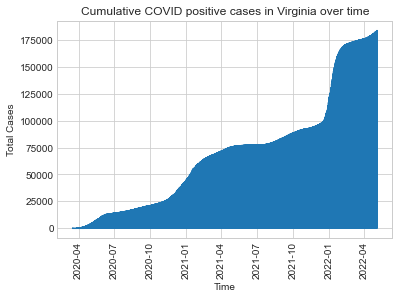

In [45]:
# Create figure and axes
fig = plt.figure()
ax = plt.axes()

# Plot with x axis as time and y axis as total cases
ax.plot(covid_data["DateTime"], covid_data["Total Cases"])

# Set labels and title
plt.xlabel("Time")
plt.ylabel("Total Cases")
plt.title("Cumulative COVID positive cases in Virginia over time")

# Rotate tickss
plt.xticks(rotation=90)
plt.show()

As expected, the total number COVID cases in Virginia goes up over time. This is pretty intuitive as there is no way for the total cases to go down because it is a cumulative measure. From this chart we can gather some information about COVID contraction rates. We see two sections with steep slopes - January 2020 and January 2021 show massive relative spikes in new cases state-wide. This comes as no surprise, as the winter months involved cold/flu season as well as lots of family gatherings which might have added to the rate of spread. 

Instead of looking only at the cumulative cases, I think it would be interesting to see how many new cases, hospitalizations, and deaths are reported over time. We will also want to assess how these values flucuate from county to county, so we will separate the data by county. Lets do some more manipulation to our data in order visualize these changes.

In [46]:
# Takes a dataframe for a specific county and adds a column that shows the number of new cases reported for each report date
def genColumnDifference(df, column):
    offsets = []
    # For each row in the dataframe
    for index, row in df.iterrows():
        if index == 0:
            offsets.append(0)
        else:
            # Compute the difference in the specified column of the current report date minus the previous report date
            offsets.append(df.at[index, column] - df.at[index-1, column])
    # Append this column to the dataframe
    df[column+" Per Day"] = offsets
    return df

county_frames = []
# For each county 
for county in counties:
    # Construct a new dataframe consisting only of rows corresponding to this county
    county_frame = covid_data.loc[covid_data["Locality"] == county]
    # Reset the indices
    county_frame = county_frame.reset_index(drop=True)
    # Get the column differences for Total Cases, Hospitalizations, and Deaths
    county_frame = genColumnDifference(county_frame, "Total Cases")
    county_frame = genColumnDifference(county_frame, "Hospitalizations")
    county_frame = genColumnDifference(county_frame, "Deaths")
    # Make a dictionary entry so we have an easy way to determine which county each frame represents
    entry = {
        "county": county,
        "df": county_frame
    }
    county_frames.append(entry)

In [47]:
# for frame in county_frames:
#     county = frame["county"]
#     df = frame["df"]
#     # print(df)
#     print("---",county,"---")
#     print(">Total Cases Per Day")
#     printMinMax(df, "Total Cases Per Day")
#     print(">Deaths Per Day")
#     printMinMax(df, "Deaths Per Day")
#     print(">Hospitalizations Per Day")
#     printMinMax(df, "Hospitalizations Per Day")
#     print()
#     print()

--- Accomack ---
>Total Cases Per Day
Min:  -109
Max:  191
>Deaths Per Day
Min:  -1
Max:  4
>Hospitalizations Per Day
Min:  -3
Max:  9


--- Albemarle ---
>Total Cases Per Day
Min:  -283
Max:  350
>Deaths Per Day
Min:  -4
Max:  7
>Hospitalizations Per Day
Min:  -5
Max:  12


--- Alleghany ---
>Total Cases Per Day
Min:  -58
Max:  64
>Deaths Per Day
Min:  -2
Max:  7
>Hospitalizations Per Day
Min:  -2
Max:  4


--- Amelia ---
>Total Cases Per Day
Min:  -15
Max:  53
>Deaths Per Day
Min:  -1
Max:  5
>Hospitalizations Per Day
Min:  -4
Max:  9


--- Amherst ---
>Total Cases Per Day
Min:  -85
Max:  133
>Deaths Per Day
Min:  -2
Max:  6
>Hospitalizations Per Day
Min:  -2
Max:  10


--- Appomattox ---
>Total Cases Per Day
Min:  -28
Max:  55
>Deaths Per Day
Min:  -2
Max:  2
>Hospitalizations Per Day
Min:  -7
Max:  8


--- Arlington ---
>Total Cases Per Day
Min:  -650
Max:  1310
>Deaths Per Day
Min:  -3
Max:  9
>Hospitalizations Per Day
Min:  -6
Max:  56


--- Augusta ---
>Total Cases Per Day
Min: 